# Fine-tuning for Video Classification with 🤗 Transformers

This notebook shows how to fine-tune a pre-trained Vision model for Video Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder and fine-tune the model altogether on a labeled dataset.


## Dataset

This notebook uses a subset of the [UCF-101 dataset](https://www.crcv.ucf.edu/data/UCF101.php). We'll be using a subset of the dataset to keep the runtime of the tutorial short. The subset was prepared using [this guide](https://www.tensorflow.org/tutorials/load_data/video). 

## Model

We'll fine-tune the [VideoMAE model](https://huggingface.co/docs/transformers/model_doc/videomae), which was pre-trained on the [Kinetics 400 dataset](https://www.deepmind.com/open-source/kinetics). However, you can extend this notebook to other video models such as [X-CLIP](https://huggingface.co/docs/transformers/model_doc/xclip#transformers.XCLIPVisionModel). 

**Note** that for models where there's no classification head already available you'll have to manually attach it (randomly initialized). But this is not the case for VideoMAE since we already have a [`VideoMAEForVideoClassification`](https://huggingface.co/docs/transformers/model_doc/xclip#transformers.XCLIPVisionModel) class.

## Data preprocessing

This notebook leverages [TorchVision's](https://pytorch.org/vision/stable/transforms.html) and [PyTorchVideo's](https://pytorchvideo.org/) transforms for applying data preprocessing transformations including data augmentation.

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In [ ]:
model_ckpt = "MCG-NJU/videomae-base-finetuned-kinetics" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

Before we start, let's install the `pytorchvideo`, `transformers`, and `evaluate` libraries.

In [ ]:
!pip install pytorchvideo transformers evaluate -q

     |████████████████████████████████| 132 kB 4.9 MB/s 
     |████████████████████████████████| 5.5 MB 36.0 MB/s 
     |████████████████████████████████| 72 kB 1.1 MB/s 
     |████████████████████████████████| 50 kB 3.9 MB/s 
     |████████████████████████████████| 30.7 MB 1.3 MB/s 
     |████████████████████████████████| 42 kB 823 kB/s 
     |████████████████████████████████| 7.6 MB 68.3 MB/s 
     |████████████████████████████████| 163 kB 88.2 MB/s 
     |████████████████████████████████| 441 kB 83.1 MB/s 
     |████████████████████████████████| 115 kB 54.2 MB/s 
     |████████████████████████████████| 212 kB 84.6 MB/s 
     |████████████████████████████████| 95 kB 5.2 MB/s 
     |████████████████████████████████| 127 kB 84.4 MB/s 
     |████████████████████████████████| 115 kB 83.2 MB/s 


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


Then you need to install Git-LFS to upload your model checkpoints:

In [ ]:
!git config --global credential.helper store

## Fine-tuning a model on an image classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on a Video Classification dataset.

Given a video, the goal is to predict an appropriate class for it, like "archery". [TODO space link]

### Loading the dataset

Here we first download the subset archive and un-archive it. 

In [ ]:
from huggingface_hub import hf_hub_download


hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

Downloading:   0%|          | 0.00/213M [00:00<?, ?B/s]

In [ ]:
!tar xf {file_path}

Now, let's investigate what is inside the archive.

In [ ]:
dataset_root_path = "UCF101_subset"

!find {dataset_root_path} | head -5

UCF101_subset
UCF101_subset/test
UCF101_subset/test/BandMarching
UCF101_subset/test/BandMarching/v_BandMarching_g07_c05.avi
UCF101_subset/test/BandMarching/v_BandMarching_g11_c01.avi


Broadly, `dataset_root_path` is organized like so:

```bash
UCF101_subset/
    train/
        BandMarching/
            video_1.mp4
            video_2.mp4
            ...
        Archery
            video_1.mp4
            video_2.mp4
            ...
        ...
    val/
        BandMarching/
            video_1.mp4
            video_2.mp4
            ...
        Archery
            video_1.mp4
            video_2.mp4
            ...
        ...
    test/
        BandMarching/
            video_1.mp4
            video_2.mp4
            ...
        Archery
            video_1.mp4
            video_2.mp4
            ...
        ...
```

Let's now count the number of total videos we have. 

In [ ]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

In [ ]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


In [ ]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[PosixPath('UCF101_subset/train/BandMarching/v_BandMarching_g14_c03.avi'),
 PosixPath('UCF101_subset/train/BandMarching/v_BandMarching_g19_c03.avi'),
 PosixPath('UCF101_subset/train/BandMarching/v_BandMarching_g11_c03.avi'),
 PosixPath('UCF101_subset/train/BandMarching/v_BandMarching_g23_c05.avi'),
 PosixPath('UCF101_subset/train/BandMarching/v_BandMarching_g14_c05.avi')]

Next up, we derive the set of labels we have in the dataset. Let's also create two dictionaries that'll be helpful when initializing the model:

* `label2id`: maps the class names to integers.
* `id2label`: maps the integers to class names. 

In [ ]:
class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


We've got 10 unique classes. For each class we have 30 videos in the training set. For the validation and evaluation sets, we have 10 videos in each class.

### Loading the model

In the next cell, we initialize a video classification model where the encoder is initialized with the pre-trained parameters and the classification head is randomly initialized. We also initialize the feature extractor associated to the model. This will come in handy during writing the preprocessing pipeline for our dataset.

In [ ]:
from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification

model_ckpt = "MCG-NJU/videomae-base-finetuned-kinetics"

feature_extractor = VideoMAEFeatureExtractor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/271 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

In [ ]:
feature_extractor

VideoMAEFeatureExtractor {
  "do_center_crop": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "VideoMAEFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "size": 224
}

### Constructing the datasets for training

For preprocessing the videos, we'll leverage the [PyTorch Video library](https://pytorchvideo.org/). We start by importing the dependencies we need. 

In [ ]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

For the training dataset transformations, we use a combination of uniform temporal subsampling, pixel normalization, random cropping, and random horizontal flipping. For the validation and evaluation dataset transformations, we keep the transformation chain the same except for random cropping and horizontal flipping. To learn more about the details of these transformations check out the [official documentation of PyTorch Video](https://pytorchvideo.org).  

In [ ]:
import os

mean = feature_extractor.image_mean
std = feature_extractor.image_std
resize_to = feature_extractor.size
num_frames_to_sample = model.config.num_frames
clip_duration = 2


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)
# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize((resize_to, resize_to)),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

**Note**: The above dataset pipelines are taken from the [official PyTorch Video example](https://pytorchvideo.org/docs/tutorial_classification#dataset). 

In [ ]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(300, 100, 100)

Let's now take a preprocessed video from the dataset and investigate it. 

In [ ]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [ ]:
def investigate_video(sample_video):
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name v_Basketball_g01_c01.avi
video_index 210
clip_index 0
aug_index 0
label 7
Video label: Basketball


We can also visualize the preprocessed videos for easier debugging. 

In [ ]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor):
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor)
    Image(filename=gif_filename)

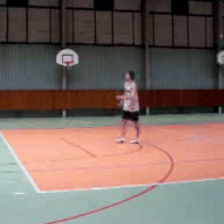

In [ ]:
gif_filename = create_gif(video_tensor)
display_gif(gif_filename)

### Training the model

We'll leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model. It also helps sync all the information in the model repository on 🤗 Hub.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 3

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we'll load now. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [ ]:
import torch


def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset into local empty directory.
max_steps is given, it will override any value given in num_train_epochs


You might wonder why we pass along the `feature_extractor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [ ]:
train_results = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 888
  Num Epochs = 9223372036854775807
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 111
  Number of trainable parameters = 86234890


Epoch,Training Loss,Validation Loss,Accuracy
0,0.927400,0.327117,0.978632
1,0.088700,0.066752,1.000000
2,0.026700,0.047148,1.000000


***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8
Saving model checkpoint to videomae-base-finetuned-kinetics-finetuned-ucf101-subset/checkpoint-38
Configuration saved in videomae-base-finetuned-kinetics-finetuned-ucf101-subset/checkpoint-38/config.json
Model weights saved in videomae-base-finetuned-kinetics-finetuned-ucf101-subset/checkpoint-38/pytorch_model.bin
***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8
Saving model checkpoint to videomae-base-finetuned-kinetics-finetuned-ucf101-subset/checkpoint-76
Configuration saved in videomae-base-finetuned-kinetics-finetuned-ucf101-subset/checkpoint-76/config.json
Model weights saved in videomae-base-finetuned-kinetics-finetuned-ucf101-subset/checkpoint-76/pytorch_model.bin
***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8
Saving model checkpoint to videomae-base-finetuned-kinetics-finetuned-ucf101-subset/checkpoint-111
Configuration saved in videomae-base-finetuned-kineti

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 8


{'eval_loss': 0.06662772595882416,
 'eval_accuracy': 1.0,
 'eval_runtime': 18.1429,
 'eval_samples_per_second': 11.905,
 'eval_steps_per_second': 1.488,
 'epoch': 2.32}

In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

***** test metrics *****
  epoch                   =       2.32
  eval_accuracy           =        1.0
  eval_loss               =     0.0666
  eval_runtime            = 0:00:18.43
  eval_samples_per_second =     11.716
  eval_steps_per_second   =      1.465


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to videomae-base-finetuned-kinetics-finetuned-ucf101-subset
Configuration saved in videomae-base-finetuned-kinetics-finetuned-ucf101-subset/config.json
Model weights saved in videomae-base-finetuned-kinetics-finetuned-ucf101-subset/pytorch_model.bin


Upload file runs/Nov07_10-06-07_3a78e7f68355/events.out.tfevents.1667815889.3a78e7f68355.105.2: 100%|#########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset
   31fdf23..50e3c4d  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset
   31fdf23..50e3c4d  main -> main



'https://huggingface.co/sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset/commit/50e3c4dc746dcc6ed8599fdd98ac9b6a51c62d42'

Now that our model is trained, let's use it to run inference on a video from `test_dataset`. 

## Inference

Let's load the trained model checkpoint and fetch a video from `test_dataset`. 

In [ ]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [ ]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name v_Archery_g15_c02.avi
video_index 24
clip_index 1
aug_index 0
label 2
Video label: Archery


We then prepare the video as a `torch.Tensor` and run inference. 

In [ ]:
def run_inference(video):
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    trained_model = trained_model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
logits = run_inference(sample_test_video["video"])

We can now check if the model got the prediction right. 

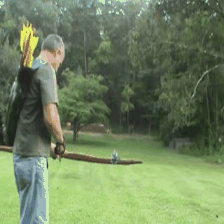

In [ ]:
gif_filename = create_gif(perumuted_sample_test_video, "test.gif")
display_gif(gif_filename)

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Archery


And it looks like it got it right!

[TODO add space link]